# 1. Import Necessary Libraries

In [ ]:
# Install necessary packages
!pip install snowflake-connector-python
!pip install snowflake-sqlalchemy
!pip install sqlalchemy
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 14.5 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import joblib

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/snowflake/sqlalchemy/base.py:1068: SAWarning: The GenericFunction 'flatten' is already registered and is going to be overridden.
  functions.register_function("flatten", flatten)


# 2. Connect to Snowflake and Load Data

In [ ]:
ACCOUNT = <account>
USER = <user>
PASSWORD = <password>
WAREHOUSE = <warehouse>
DATABASE = <database>
SCHEMA = <schema>

# Create connection URL
engine = create_engine(URL(
    account=ACCOUNT,
    user=USER,
    password=PASSWORD,
    warehouse=WAREHOUSE,
    database=DATABASE,
    schema=SCHEMA,
))

# Create a connection
connection = engine.connect()

# Load data into pandas DataFrames
customer_segment = pd.read_sql_query("SELECT * exclude (country, segment) FROM customer_demographic", connection)
prospective_buyer = pd.read_sql_query("SELECT * FROM prospect_demographic", connection)

# Close the connection
connection.close()

In [ ]:
customer_segment.head()

,age,maritalstatus,gender,yearlyincome,totalchildren,numberchildrenathome,education,occupation,houseownerflag,numbercarsowned,bikebuyer
0,43,M,M,90000,2,0,Bachelors,Professional,1,0,1
1,38,S,M,60000,3,3,Bachelors,Professional,0,1,1
2,43,M,M,60000,3,3,Bachelors,Professional,1,1,1
3,41,S,F,70000,0,0,Bachelors,Professional,0,1,1
4,35,S,F,80000,5,5,Bachelors,Professional,1,4,1


# 3. Data Exploration


In [ ]:
# Check the shape of the dataset
print(f'Dataset contains {customer_segment.shape[0]} rows and {customer_segment.shape[1]} columns.')

# Summary of the dataset
customer_segment.info()

Dataset contains 18484 rows and 11 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   age                   18484 non-null  int64 
 1   maritalstatus         18484 non-null  object
 2   gender                18484 non-null  object
 3   yearlyincome          18484 non-null  int64 
 4   totalchildren         18484 non-null  int64 
 5   numberchildrenathome  18484 non-null  int64 
 6   education             18484 non-null  object
 7   occupation            18484 non-null  object
 8   houseownerflag        18484 non-null  int64 
 9   numbercarsowned       18484 non-null  int64 
 10  bikebuyer             18484 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 1.6+ MB


In [ ]:
# Statistical summary of numerical features
customer_segment.describe()

,age,yearlyincome,totalchildren,numberchildrenathome,houseownerflag,numbercarsowned,bikebuyer
count,18484.000000,18484.000000,18484.000000,18484.000000,18484.000000,18484.000000,18484.000000
mean,45.176531,57305.777970,1.844352,1.004058,0.676369,1.502705,0.494049
std,11.536142,32285.841703,1.612408,1.522660,0.467874,1.138394,0.499978
min,28.000000,10000.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,36.000000,30000.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,43.000000,60000.000000,2.000000,0.000000,1.000000,2.000000,0.000000
75%,53.000000,70000.000000,3.000000,2.000000,1.000000,2.000000,1.000000
max,98.000000,170000.000000,5.000000,5.000000,1.000000,4.000000,1.000000


In [ ]:
# Check for missing values
customer_segment.isnull().sum()

,0
age,0
maritalstatus,0
gender,0
yearlyincome,0
totalchildren,0
numberchildrenathome,0
education,0
occupation,0
houseownerflag,0
numbercarsowned,0


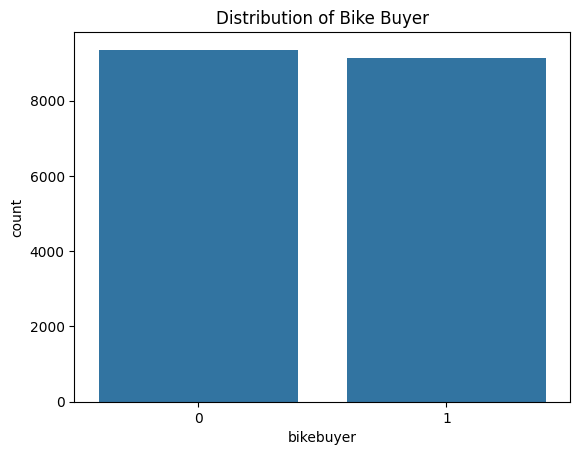

In [ ]:
# Count plot of the target variable
sns.countplot(x='bikebuyer', data=customer_segment)
plt.title('Distribution of Bike Buyer')
plt.show()

In [ ]:
# List of categorical variables
categorical_vars = ['maritalstatus', 'gender', 'education', 'occupation']

# Use OneHotEncoder or LabelEncoder
df_encoded = pd.get_dummies(customer_segment, columns=categorical_vars, drop_first=True)

In [ ]:
# List of numerical features
numerical_vars = ['age', 'yearlyincome', 'totalchildren', 'numberchildrenathome', 'houseownerflag', 'numbercarsowned']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
df_encoded[numerical_vars] = scaler.fit_transform(df_encoded[numerical_vars])

# 4. Feature Selection

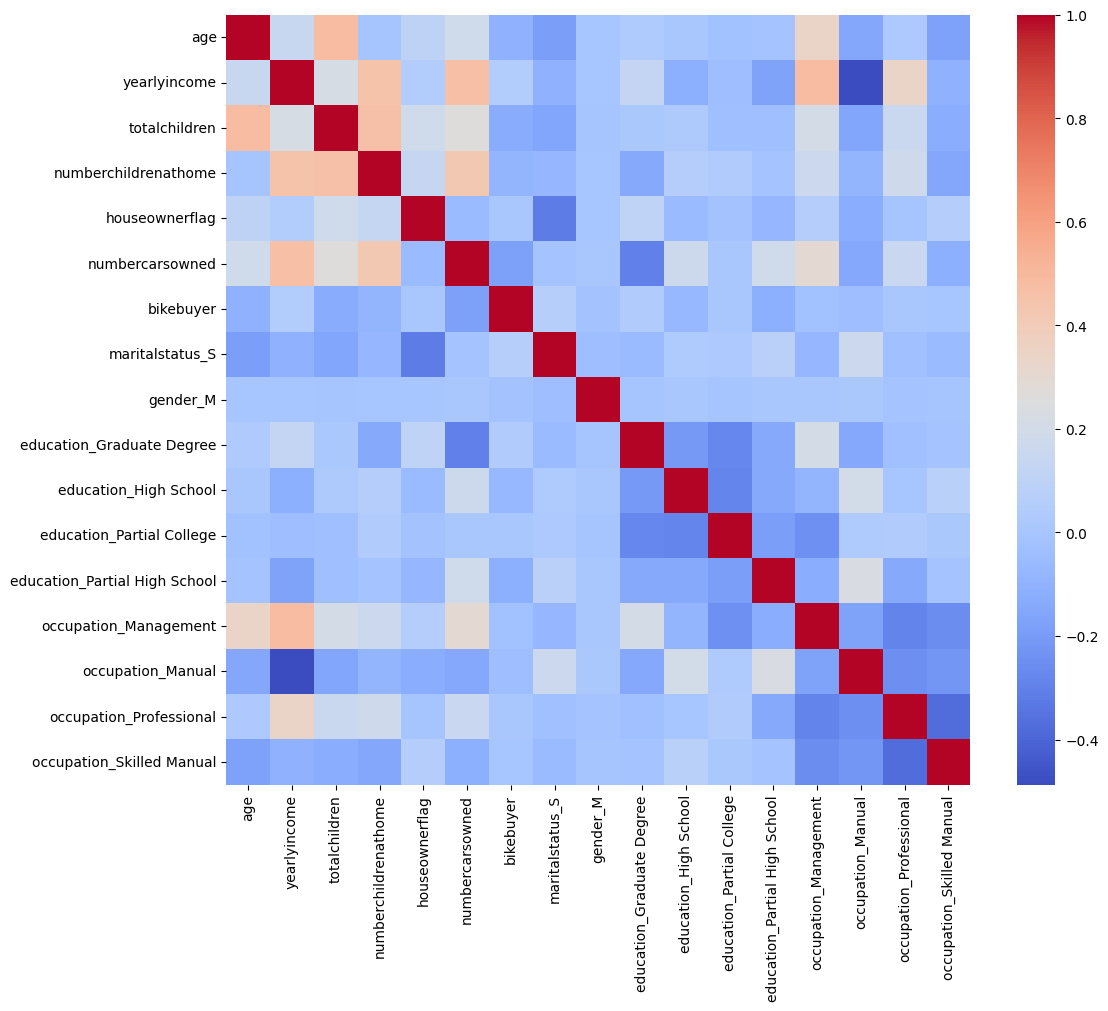

In [ ]:
# Correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df_encoded.corr(), cmap='coolwarm')
plt.show()

# 5. Split the Data

In [ ]:
# Features and target variable
X = df_encoded.drop('bikebuyer', axis=1)
y = df_encoded['bikebuyer']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Build the Classification Model

In [ ]:
# Initialize the model
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Make predictions
y_pred = rfc.predict(X_test)

# 7. Evaluate Metrics

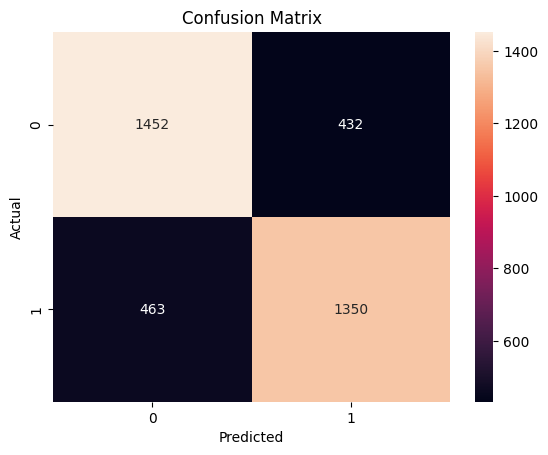

              precision    recall  f1-score   support

           0       0.76      0.77      0.76      1884
           1       0.76      0.74      0.75      1813

    accuracy                           0.76      3697
   macro avg       0.76      0.76      0.76      3697
weighted avg       0.76      0.76      0.76      3697

Accuracy: 75.79%


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')

In [ ]:
# ROC Curve and AUC
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities for the positive class
y_probs = rfc.predict_proba(X_test)[:, 1]

# Calculate False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate AUC
auc = roc_auc_score(y_test, y_probs)
print(f'AUC: {auc:.2f}')

AUC: 0.83


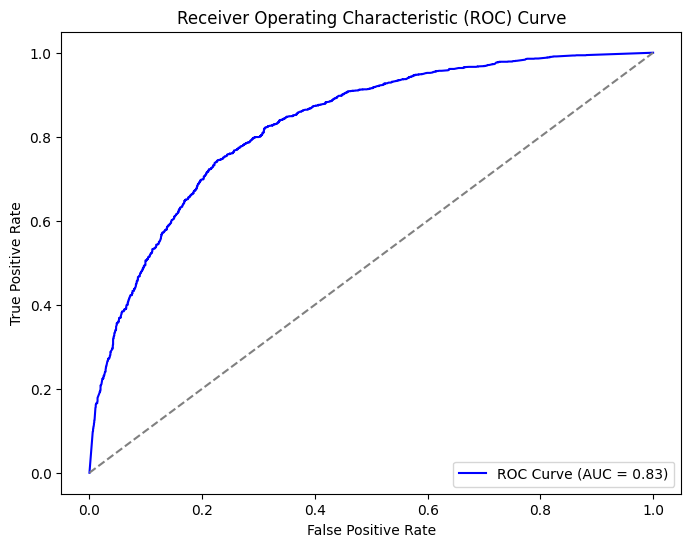

In [ ]:
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line for random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.metrics import log_loss

# Calculate Log Loss
logloss = log_loss(y_test, y_probs)
print(f'Log Loss: {logloss:.4f}')

Log Loss: 0.7277


# 8. Feature Importance Evaluation

In [ ]:
# Get feature importances from the Random Forest model
importances = rfc.feature_importances_

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort the features by importance
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

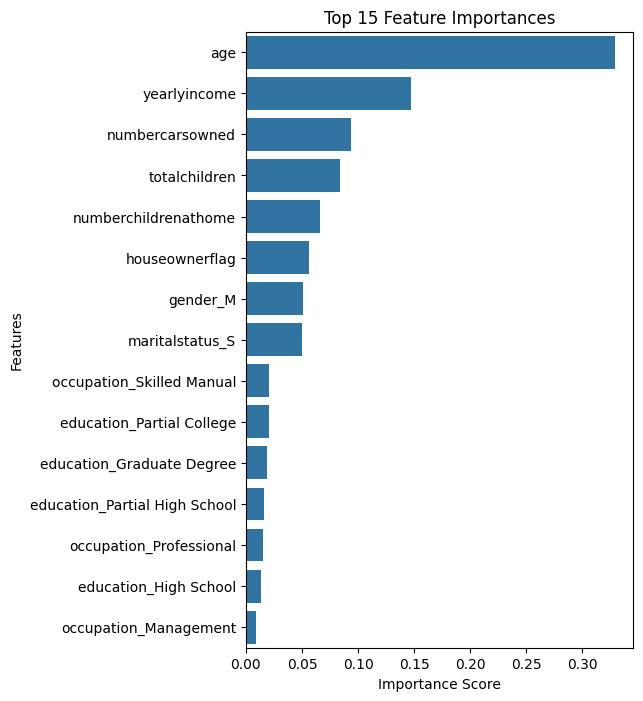

In [ ]:
# Plot the feature importances
plt.figure(figsize=(5, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15))
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# 9. Apply the model to prospect buyer dataset

In [ ]:
# Display the first few rows
prospective_buyer.head()

,prospectivebuyerkey,age,maritalstatus,gender,yearlyincome,totalchildren,numberchildrenathome,education,occupation,houseownerflag,numbercarsowned,city,stateprovincecode
0,1,69,M,M,40000,3,0,Partial Co,Professional,1,2,Cedar City,UT
1,2,64,M,F,80000,4,0,Bachelors,Management,1,2,Colma,CA
2,3,50,S,M,130000,3,4,Partial Co,Professional,1,4,Lynnwood,WA
3,4,29,S,M,50000,0,0,Partial Co,Skilled Manual,1,2,Chula Vista,CA
4,5,49,M,F,10000,2,0,Partial Co,Manual,1,0,Dallas,TX


In [ ]:
# Check for missing values
prospective_buyer.isnull().sum()

,0
prospectivebuyerkey,0
age,0
maritalstatus,0
gender,0
yearlyincome,0
totalchildren,0
numberchildrenathome,0
education,0
occupation,0
houseownerflag,0


In [ ]:
# Fix known typos or abbreviations in prospective_buyers
prospective_buyer['education'].replace({
    'Graduate D': 'Graduate Degree',
    'High Schoo': 'High School',
    'Partial Co': 'Partial College',
    'Partial Hi': 'Partial High School'
}, inplace=True)

In [ ]:
# List of categorical variables
categorical_vars = ['maritalstatus', 'gender', 'education', 'occupation']

# Combine the training and prospective data for consistent encoding
# Load the original training data (assuming it's available)
training_df = customer_segment

# Concatenate for consistent encoding
combined_df = pd.concat([training_df[categorical_vars], prospective_buyer[categorical_vars]], axis=0)

# Perform one-hot encoding
combined_encoded = pd.get_dummies(combined_df, columns=categorical_vars, drop_first=True)

# Split back into training and prospective encoded data
encoded_columns = combined_encoded.columns
prospective_encoded = combined_encoded[len(training_df):]

# Ensure the prospective data has the same columns
prospective_encoded = prospective_encoded.reindex(columns=encoded_columns, fill_value=0)

In [ ]:
# List of numerical features
numerical_vars = ['age', 'yearlyincome', 'totalchildren', 'numberchildrenathome', 'houseownerflag', 'numbercarsowned']

# Load and apply the same scaler used during training
scaler = StandardScaler()
scaler.fit(training_df[numerical_vars])

# Transform the prospective data
prospective_buyer[numerical_vars] = scaler.transform(prospective_buyer[numerical_vars])

In [ ]:
# Combine numerical and encoded categorical features
X_prospective = pd.concat([prospective_buyer[numerical_vars].reset_index(drop=True), prospective_encoded.reset_index(drop=True)], axis=1)

In [ ]:
# Make predictions
prospective_buyer['bikebuyer_prediction'] = rfc.predict(X_prospective)

In [ ]:
results_df = prospective_buyer[['prospectivebuyerkey', 'bikebuyer_prediction']]
results_df.head()

,prospectivebuyerkey,bikebuyer_prediction
0,1,0
1,2,0
2,3,0
3,4,1
4,5,0


In [ ]:
# Name of the table to write to
table_name = 'PROSPECT_PREDICTION'

# Write the DataFrame to Snowflake
try:
    results_df.to_sql(table_name, con=engine, if_exists='replace', index=False)
    print(f"Data successfully written to table '{table_name}' in Snowflake.")
except Exception as e:
    print(f"An error occurred: {e}")

Data successfully written to table 'PROSPECT_PREDICTION' in Snowflake.


# 10. Analyzing Model Predictions and Feature Distributions

In [ ]:
# Generate predicted probabilities
prospective_buyer['bikebuyer_prob'] = rfc.predict_proba(X_prospective)[:, 1]

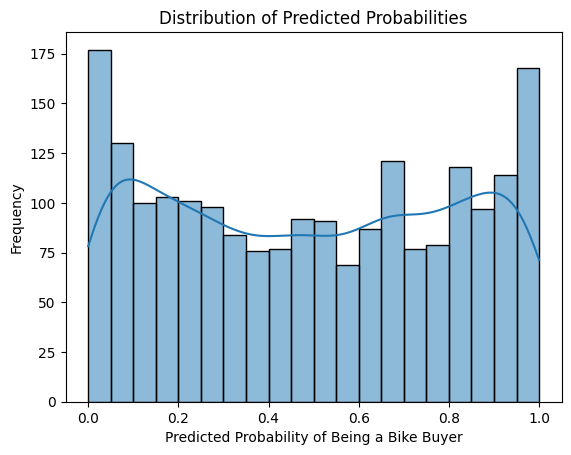

In [ ]:
import seaborn as sns

sns.histplot(prospective_buyer['bikebuyer_prob'], bins=20, kde=True)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability of Being a Bike Buyer')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Compute correlation between predicted probabilities and numerical features
corr = prospective_buyer[['bikebuyer_prob'] + numerical_vars].corr()
print(corr['bikebuyer_prob'].sort_values(ascending=False))

bikebuyer_prob          1.000000
yearlyincome            0.045859
houseownerflag         -0.074667
age                    -0.177758
numberchildrenathome   -0.191508
totalchildren          -0.244469
numbercarsowned        -0.291144
Name: bikebuyer_prob, dtype: float64


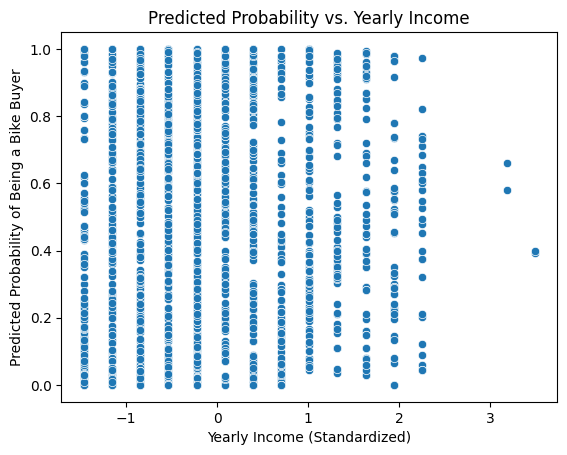

In [ ]:
# Scatter plot of predicted probabilities vs. YearlyIncome
sns.scatterplot(x='yearlyincome', y='bikebuyer_prob', data=prospective_buyer)
plt.title('Predicted Probability vs. Yearly Income')
plt.xlabel('Yearly Income (Standardized)')
plt.ylabel('Predicted Probability of Being a Bike Buyer')
plt.show()